# Modelo do Pêndulo de Furuta

Implementação baseada nas [notas de aula](https://edisciplinas.usp.br/pluginfile.php/8325470/mod_resource/content/2/Octave_LQR_AlocPolo.pdf) do Prof. Dr. Flávio Trigo. 

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Paleta de cores
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839, 0.0, 0.027),
    'dgreen': (0.341, 0.494, 0.094),
    'dblue': (0.063, 0.318, 0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

## 1. Parâmetros

In [3]:
# Dimensões do modelo
n = 4           # variáveis de estados
r = 1           # entradas
m = 2           # saídas
l = 2           # perturbações

# Parâmetros principais
J1 = 0.05       # [kg m**2]
l1 = 0.2        # [m]
M2 = 0.15       # [kg]
l2 = 0.5        # [m]
J2 = M2 * l2 ** 2 / 3  # [kg m**2]
K_φ = 0.008     
N = 15          
R = 2.5         # [Ω]
g = 9.8         # [kg * m/s]

# Parâmetros calculados auxiliares
m11 = J1 + M2 * l1 ** 2
m12 = 1 / 2 * M2 * l1 * l2
m22 = J2
d = 1 / 2 * M2 * g * l2
e = N * K_φ / R
f = N ** 2 * K_φ ** 2 / R
Δ = m11 * m22 - m12 ** 2

## 2. Sistema Linearizado

In [4]:
# Matrizes do Sistema Linearizado
A = np.array([[0, 0, 1, 0],
              [0, 0, 0, 1],
              [0, -m12 * d / Δ, -m22 * f / Δ, 0],
              [0, m11 * d / Δ, m12 * f / Δ, 0]])
B = np.array([[0], [0], [m22 * e / Δ], [-m12 * e / Δ]])
E = np.array([[0, 0], [0, 0], [m22 / Δ, -m12 / Δ], [-m12 / Δ, m11 / Δ]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
D = np.array([[0], [0]])

In [5]:
# Sistema em malha aberta na forma de espaço de estados
furuta_OL_SS = ct.ss(A, B, C, D)
furuta_OL_SS

<LinearIOSystem:sys[2]:['u[0]']->['y[0]', 'y[1]']>

### 2.1. Verificação de controlabilidade e observabilidade

In [6]:
print('Posto de controlabilidade = ', np.linalg.matrix_rank(ct.ctrb(A, B)))
print('Posto de observabilidade = ', np.linalg.matrix_rank(ct.obsv(A, C)))

Posto de controlabilidade =  4
Posto de observabilidade =  4


### 2.2. Verificação de estabilidade: autovalores da matriz A

In [7]:
print("autovalores de A = ", np.linalg.eig(A)[0])

autovalores de A =  [ 0.          5.64969585 -5.65868634 -0.10285417]


## 3. Projeto de controlador por alocação de pólos

In [8]:
# Matriz de ganhos de controle
K_pp = ct.place(A, B, 
                [-1.25 - 1.25j, -1.25 + 1.25j, -2, -2.5])  # "conservador"
# K_pp = ct.place(A, B, [-7+3j, -7-3j, -0.5, -0.6]) # "agressivo"

In [9]:
# Verificação dos autovalores de (A - B K)
print("polos de malha fechada = ",
      np.linalg.eig(A - np.dot(B, K_pp))[0])

polos de malha fechada =  [-2.5 +0.j   -2.  +0.j   -1.25+1.25j -1.25-1.25j]


In [10]:
# Sistema em malha fechada na forma de espaço de estados
furuta_CLPP_SS = ct.ss(A - np.dot(B, K_pp), E, -K_pp, 0)
furuta_CLPP_SS

<LinearIOSystem:sys[3]:['u[0]', 'u[1]']->['y[0]']>

### 3.1. Simulação numérica do sistema controlado

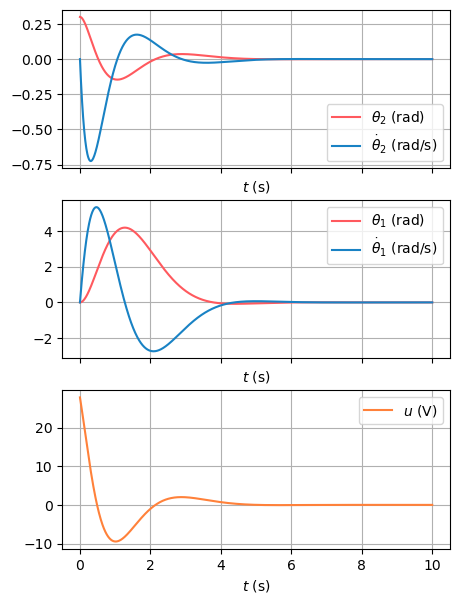

In [11]:
ts = np.linspace(0, 10, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.0, 0.3, 0.0, 0.0]
t, u, x = ct.forced_response(furuta_CLPP_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (state_pend, state_base, control_input) = plt.subplots(
    3, 1, figsize=(5, 7), sharex=True)

state_pend.plot(t, x[1, :], color=cp['red'], label=r'$\theta_2$ (rad)')
state_pend.plot(t, x[3, :], color=cp['blue'], label=r'$\dot \theta_2$ (rad/s)')
# state_pend.set_ylabel(r'$x$')
state_pend.set_xlabel(r'$t$ (s)')
state_pend.legend()
state_pend.grid()

state_base.plot(t, x[0, :], color=cp['red'], label=r'$\theta_1$ (rad)')
state_base.plot(t, x[2, :], color=cp['blue'], label=r'$\dot \theta_1$ (rad/s)')
# state_base.set_ylabel(r'$x$')
state_base.set_xlabel(r'$t$ (s)')
state_base.legend()
state_base.grid()

control_input.plot(t, u[0, :], color=cp['orange'], label=r'$u$ (V)')
# control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

## 4.  Projeto de controlador LQR

In [12]:
Q = np.diag([10, 10, 0.1, 0.1])
R = 1

# Matriz de ganhos de controle
K_lq, P_lq, poles_lq = ct.lqr(furuta_OL_SS, Q, R)

# Polos do sistema em malha fechada
poles_lq

array([-5.65585021+0.12980871j, -5.65585021-0.12980871j,
       -1.17683774+1.14999148j, -1.17683774-1.14999148j])

In [13]:
# Sistema em malha fechada na forma de espaço de estados
furuta_CLLQ_SS = ct.ss(A - np.dot(B, K_lq), E, -K_lq, 0)
furuta_CLLQ_SS

<LinearIOSystem:sys[4]:['u[0]', 'u[1]']->['y[0]']>

### 4.1. Simulação numérica do sistema controlado

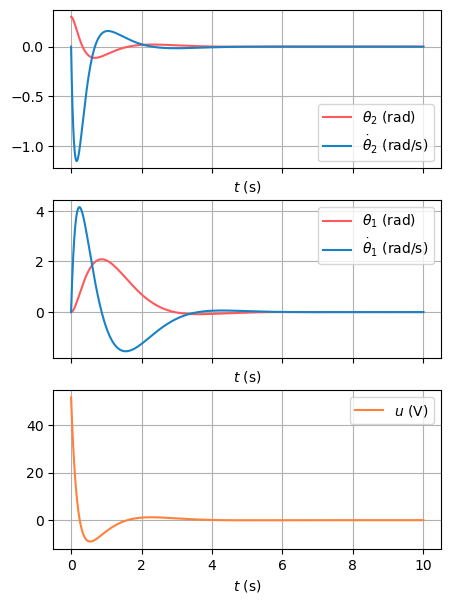

In [14]:
ts = np.linspace(0, 10, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.0, 0.3, 0.0, 0.0]
t, u, x = ct.forced_response(furuta_CLLQ_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (state_pend, state_base, control_input) = plt.subplots(
    3, 1, figsize=(5, 7), sharex=True)

state_pend.plot(t, x[1, :], color=cp['red'], label=r'$\theta_2$ (rad)')
state_pend.plot(t, x[3, :], color=cp['blue'], label=r'$\dot \theta_2$ (rad/s)')
# state_pend.set_ylabel(r'$x$')
state_pend.set_xlabel(r'$t$ (s)')
state_pend.legend()
state_pend.grid()

state_base.plot(t, x[0, :], color=cp['red'], label=r'$\theta_1$ (rad)')
state_base.plot(t, x[2, :], color=cp['blue'], label=r'$\dot \theta_1$ (rad/s)')
# state_base.set_ylabel(r'$x$')
state_base.set_xlabel(r'$t$ (s)')
state_base.legend()
state_base.grid()

control_input.plot(t, u[0, :], color=cp['orange'], label=r'$u$ (V)')
# control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

## 5. Seguidor de referência via modelo assumido

Modelo para referencia

In [15]:
# degrau ou rampa
A_r = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0]])

# seno/cosseno amortecido para posição/velocidade
# ω_s = 1.0        # [rad/s]
# ζ_s = 0         
# A_r = np.array([[0, 0, 1, 0],
                 [0, 0, 0, 1], 
                [-ω_s ** 2, 0, -2 * ζ_s * ω_s, 0], 
                [0, 0, 0, 0]])

Ganho de pré-alimentação

In [16]:
# seleção de variável para seguir referência
M = np.array([[1, 0, 0, 0]])

# inversa da matriz de estados em MF
A_cl_inv = np.linalg.inv(A - B @ K_lq)

# ganho de pré-alimentação
N = np.linalg.inv(M @ A_cl_inv @ B) @ M @ A_cl_inv
G_r = N @ (A - A_r)

Colocando o sistema em malha aberta na forma de espaço de estados:

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}
    \begin{bmatrix}
        x(t) \\ e(t) 
    \end{bmatrix}
    = 
    \begin{bmatrix}
        A & 0 \\ (A_r - A) & A_r
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ e(t)
    \end{bmatrix}
    +
    \begin{bmatrix}
        B \\ - B
    \end{bmatrix}
    u(t)
\end{align*}
com $e(t) = x_r(t) - x(t) \ \Leftrightarrow \ x_r(t) = x(t) + e(t)$.

Adotando a lei de controle:
\begin{align*}
    u(t) = K e(t) - G_r x_r(t) = \begin{bmatrix}
        - G_r & K - G_r
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ e(t)
    \end{bmatrix}
\end{align*}
com $G_r = N(A-A_r)$, pode-se estabelecer a dinâmica do sistema aumentado em malha-fechada:

\begin{align*}
    \frac{\mathrm{d}}{\mathrm{d}t}
    \begin{bmatrix}
        x(t) \\ e(t) 
    \end{bmatrix}
    = 
    \begin{bmatrix}
        A - B G_r & B (K - G_r) \\ A_r - A + B G_r & A_r - B (K - G_r)
    \end{bmatrix}
    \begin{bmatrix}
        x(t) \\ e(t)
    \end{bmatrix}
\end{align*}



In [20]:
# matrizes do sistema estendido em malha fechada
A_ex_cl = np.block([[A - B @ G_r, B @ (K_lq - G_r)], 
                    [A_r - A + B @ G_r, A_r - B @ (K_lq - G_r)]])
E_ex_cl = np.block([[E], [np.zeros((n, l))]])
K_ex = np.block([[-G_r, K_lq - G_r]])

# forma de espaço de estados
furuta_ex_cl_SS = ct.ss(A_ex_cl, E_ex_cl, K_ex, 0)
furuta_ex_cl_SS

<LinearIOSystem:sys[6]:['u[0]', 'u[1]']->['y[0]']>

### 5.1. Simulação do sistema com seguidor em malha fechada

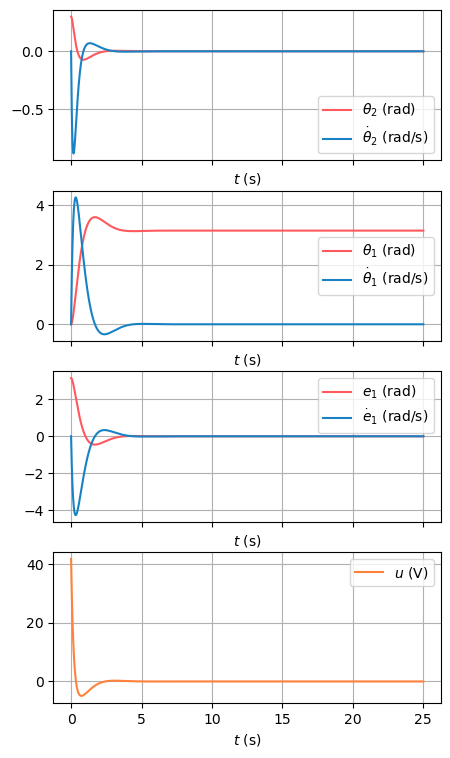

In [22]:
ts = np.linspace(0, 25, 1001)
w = np.linspace(0.1, 0.1, 1001)
x0 = [0.0, 0.3, 0.0, 0.0, 
      np.pi, 0.0, 0.0, 0.0]
# x0 = [0.0, 0.3, 0.0, 0.0,
#       0.0, 0.0, 1.0, 0.0]
t, u, x = ct.forced_response(furuta_ex_cl_SS, U=0, T=ts, X0=x0, return_x=True)

fig, (state_pend, state_base, error_base, control_input) = plt.subplots(
    4, 1, figsize=(5, 9), sharex=True)

state_pend.plot(t, x[1, :], color=cp['red'], label=r'$\theta_2$ (rad)')
state_pend.plot(t, x[3, :], color=cp['blue'], label=r'$\dot \theta_2$ (rad/s)')
state_pend.set_xlabel(r'$t$ (s)')
state_pend.legend()
state_pend.grid()

state_base.plot(t, x[0, :], color=cp['red'], label=r'$\theta_1$ (rad)')
state_base.plot(t, x[2, :], color=cp['blue'], label=r'$\dot \theta_1$ (rad/s)')
state_base.set_xlabel(r'$t$ (s)')
state_base.legend()
state_base.grid()

error_base.plot(t, x[4, :], color=cp['red'], label=r'$e_1$ (rad)')
error_base.plot(t, x[6, :], color=cp['blue'], label=r'$\dot e_1$ (rad/s)')
error_base.set_xlabel(r'$t$ (s)')
error_base.legend()
error_base.grid()

control_input.plot(t, u[0, :], color=cp['orange'], label=r'$u$ (V)')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

### 5.2. Animação da simulação

MovieWriter imagemagick unavailable; using Pillow instead.


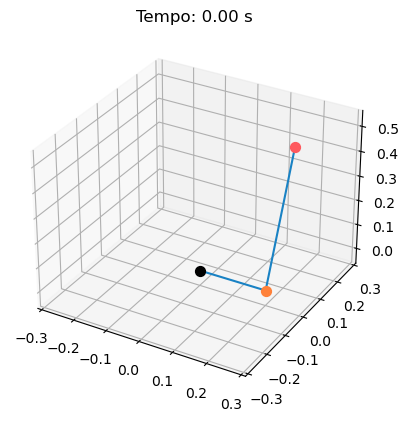

In [19]:
# Função para calcular as coordenadas de B e C a partir de q1 e q2
def joints_positions(q1, q2, l1=0.2, l2=0.5):
    x_b = l1 * np.cos(q1)
    y_b = l1 * np.sin(q1)
    x_c = x_b - l2 * np.sin(q2) * np.sin(q1)
    y_c = y_b + l2 * np.sin(q2) * np.cos(q1)
    z_c = l2 * np.cos(q2)
    return x_b, y_b, 0, x_c, y_c, z_c

# Número de quadros por segundo (fps)
fps = 30

# Função para atualizar o frame da animação
def update_frame(frame):
    ax.clear()
    # Suponha que a primeira linha de x contém os valores de q1 e a segunda linha contém os valores de q2
    q1 = x[0, frame]
    q2 = x[1, frame]
    x_b, y_b, z_b, x_c, y_c, z_c = joints_positions(q1, q2)
    ax.plot([0, x_b, x_c], [0, y_b, y_c], [0, z_b, z_c],
            '-o', color=cp['blue'])  # Linha do robô
    ax.scatter([0], [0], [0], color=['black'], s=50)  # Ponto A
    ax.scatter([x_b], [y_b], [z_b], color=cp['orange'], s=50)  # Ponto B
    ax.scatter([x_c], [y_c], [z_c], color=cp['red'], s=50)  # Ponto C
    ax.set_xlim(-0.30, 0.30)
    ax.set_ylim(-0.30, 0.30)
    ax.set_zlim(-0.05, 0.55)
    ax.set_title(f'Tempo: {frame / 100:.2f} s')

# Criando a figura e o eixo 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configurações da animação
num_frames = x.shape[1]  # Número de colunas em x
interval = 1000 / fps  # Intervalo de tempo entre frames em milissegundos

# Criando a animação
ani = animation.FuncAnimation(
    fig, update_frame, frames=num_frames, interval=interval)

# Salvando a animação como um arquivo GIF
ani.save('furuta_.gif', writer='imagemagick', fps=fps)